1. Load Data

In [2]:
import os
import pandas as pd
from sklearn import preprocessing

filename = 'select_preprocess_label_atop.csv'
folder = os.path.join("..", "0_dataset", "accounting")
models_folder = "models_accounting"
data_type = 'Accounting'

df = pd.read_csv(os.path.join(folder, filename))
print(df.info)


# build labeling map
label_original = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))


X = df.drop(columns=['Label'])
X = X.to_numpy()
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)

<bound method DataFrame.info of            RDDSK     WRDSK    WCANCL       DSK    MINFLT     MAJFLT    VSTEXT  \
0      17.139735 -0.106281 -0.082612  2.229131  1.536001  50.490123 -0.239907   
1      -0.006479 -0.106281 -0.082612 -0.168107  0.864369  -0.019613 -0.241115   
2      -0.006479 -0.106281 -0.082612 -0.168107  1.371429  -0.019613 -0.224605   
3      -0.006479 -0.106281 -0.082612 -0.168107  1.567136  -0.019613 -0.239907   
4      -0.006479 -0.106281 -0.082612 -0.168107  1.576032  -0.019613 -0.239102   
...          ...       ...       ...       ...       ...        ...       ...   
65664  -0.006479 -0.106281 -0.082612 -0.168107  0.239440  -0.019613 -0.243733   
65665  -0.006479 -0.106281 -0.082612 -0.168107  0.239440  -0.019613 -0.243733   
65666  -0.006479 -0.106281 -0.082612 -0.168107  0.239440  -0.019613 -0.243733   
65667  -0.006479 -0.106281 -0.082612 -0.168107  0.239440  -0.019613 -0.243733   
65668  -0.006479 -0.106281 -0.082612 -0.168107  0.239440  -0.019613 -0.243733

2. Define the Models

In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers
import pickle
import numpy as np


if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is not available')


core = -1 # your computer's maximum core numbers, for improving the training speed


models = {}
# traditional machine learning
# linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
# non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
# models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
# ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
# models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)

dl_models = {}
# deep learning
dl_models['DNN'] = tf.keras.Sequential([
    layers.Dense(256, input_shape=(X.shape[1],), activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(label_original), activation='softmax'),
], name='DNN')

for name in dl_models:
    dl_models[name].summary()

GPU is available
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               8704      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)       

3. Training, testing, and evaluation

In [4]:
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import math


batch_size = 16
epochs = 100
lr = 2e-5 # 5e-4, 2e-5, 3e-5
random_seed = 42


# training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_original))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


# train_steps = math.ceil(len(X_train) / batch_size)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    # num_train_steps=train_steps,
    # num_warmup_steps=int(0.1*train_steps),
    # optimizer_type='adamw',
    name='adam'
)
# earlystop_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.0001,
#     patience=10,
#     verbose=1,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=True,
# )
evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
for name in dl_models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }


for name, model in models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test)
    end_time = time.time()
    print("model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))

for name, model in dl_models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name + '.h5')
    if os.path.exists(model_filename): # load the model from disk
        model = tf.keras.models.load_model(model_filename)
    else:
        model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer=optimizer, 
            metrics=['sparse_categorical_accuracy']
        )
        model.fit(
            X_train, y_train, 
            batch_size=batch_size, epochs=epochs, 
            validation_data=(X_test, y_test)
        )
        model.save(model_filename, save_format='h5')
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1) # turn one-hot format to label
    end_time = time.time()
    print("DL model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))


c:\Users\user\anaconda3\envs\lab\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


original labels:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17]
X_train:639152, y_train:639152
model: Logistic_Regression 
execution time: 0.01

model: SGD 
execution time: 0.01

model: Passive_Aggressive 
execution time: 0.01

model: Decision_Tree 
execution time: 0.02

model: Extra_Tree 
execution time: 0.03

model: Naive_Bayes 
execution time: 0.07

model: KNN 
execution time: 6.08

model: Random_Forest 
execution time: 0.68

model: Bagging 
execution time: 2.03

model: Extra_Trees 
execution time: 1.81

model: Gradient_Boosting 
execution time: 0.23

model: XGBoost 
execution time: 0.09

411/411 [==============================] - 4s 8ms/step
DL model: DNN 
execution time: 5.50



4. Show the model evalution result (F1 score)

In [5]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math

def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))

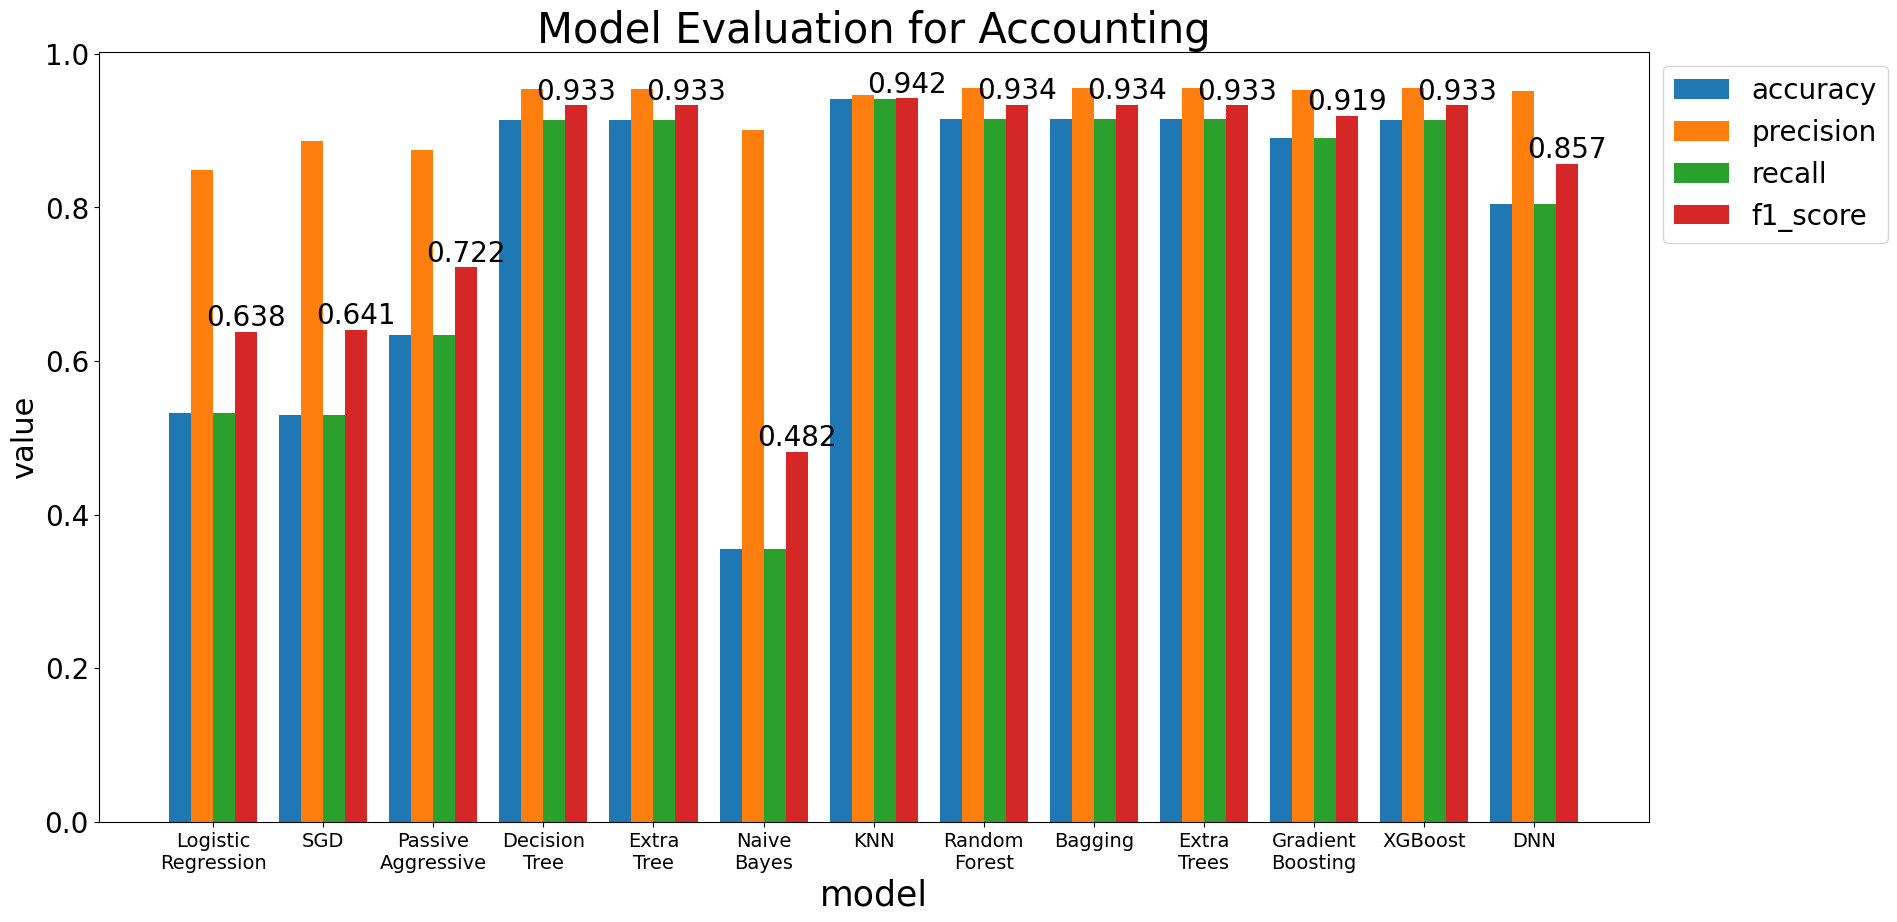

In [9]:
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 20,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.show()

5. selected accounting model (confusion matrix, learning curve) 

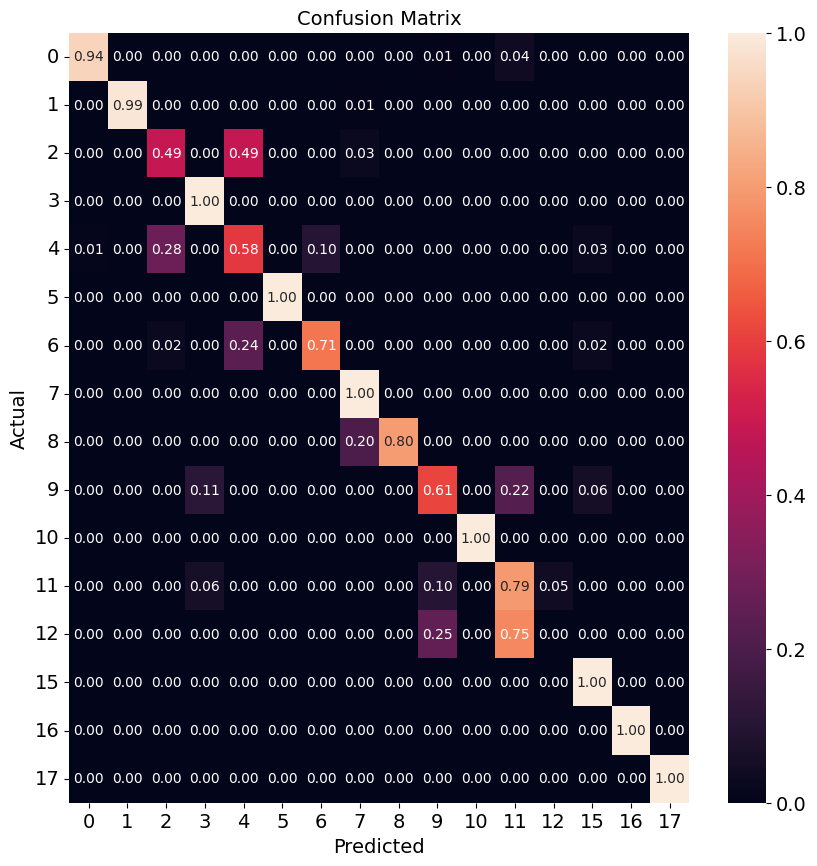

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

name = 'XGBoost'
model_filename = os.path.join(models_folder, name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_original
# model = tf.keras.models.load_model(model_filename)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)